# Cross-Validation for Metamodels

**Objective**: Demonstrate how cross-validation improves metamodel validation compared to single train-test splits

- Principles for validating metamodels
- Case study: Polynomial metamodel of sin(x) function using fractional factorial design
- Take away message



![Metamodel Validation Framework](DoE%20CV%20-%20page%201.png)

### Reminder
- Metamodel: an approximate model of the relationship between input and output variables of a more complex simulation model
- Purpose: reduce computational cost, facilitate analysis, support optimization

### Validation Framework by Kleijnen et al. (2000)

Consider validating a metamodel with respect to both the **underlying simulation** and the **problem entity**

The strategy and effort put in the validation step depends on the goal of the metamodel:
- Understanding
- Prediction
- Optimization
- Verification and validation

## Case Study: Polynomial metamodel of sin(x) function using fractional factorial design

In [26]:

import openturns as ot
from math import pi

# Define the model (simulation)
model = ot.SymbolicFunction(['x'], ['sin(x)'])

# Step 8: DOE Specification (Kleijnen et al. 2000)
# Strategic decisions:
design_type = "Fractional Factorial"  # Design type choice
levels = 2                            # Number of levels per factor
resolution = 3                        # Resolution III design
domain = (-pi/2, pi/2)               # Input domain

# For 1D example: create fractional-like design with multiple levels
# Using systematic grid points (factorial approach for 1D)
n_levels = 9  # Equivalent to 2^3 + center point
factorial_points = ot.Box([n_levels-1]).generate()  # Grid from [0,1]
# Transform to domain
x_train_raw = factorial_points * (domain[1] - domain[0]) + domain[0]

# Add center points and edge points (fractional factorial strategy)
center_point = ot.Sample([[0.0]])  # Center of domain
edge_points = ot.Sample([[-pi/4], [pi/4]])  # Quarter points
x_train = ot.Sample(x_train_raw)
x_train.add(center_point)
x_train.add(edge_points)

n_training = x_train.getSize()
n_validation = 25                     # Random validation points

# Tactical decisions:
# - Deterministic model (no replications needed)
# - Systematic training + random validation

print(f"DOE Strategy: {design_type}")
print(f"Training points: {n_training} (systematic grid + center/edge)")
print(f"Validation points: {n_validation} (random)")
print(f"Domain: {domain}")

# Generate model responses
y_train = model(x_train)

# Metamodel specification
total_degree = 3
polynomialCollection = [f'x^{degree + 1}' for degree in range(total_degree)]
basis = ot.SymbolicFunction(['x'], polynomialCollection)
designMatrix = basis(x_train)
myLeastSquares = ot.LinearLeastSquares(designMatrix, y_train)
myLeastSquares.run()
leastSquaresModel = myLeastSquares.getMetaModel()
metaModel = ot.ComposedFunction(leastSquaresModel, basis)
# Validate the metamodel using a test sample
dist = ot.Uniform(domain[0], domain[1])  # Define distribution for validation
x_test = dist.getSample(n_validation)
y_test = model(x_test)
metamodelPredictions = metaModel(x_test)
val = ot.MetaModelValidation(y_test, metamodelPredictions)
# Compute the R2 score
r2Score = val.computeR2Score()
# Get the residual
residual = val.getResidualSample()
# Get the histogram of residuals
histoResidual = val.getResidualDistribution(False)
# Draw the validation graph
graph = val.drawValidation()

DOE Strategy: Fractional Factorial
Training points: 13 (systematic grid + center/edge)
Validation points: 25 (random)
Domain: (-1.5707963267948966, 1.5707963267948966)


R² Score: 1.0000


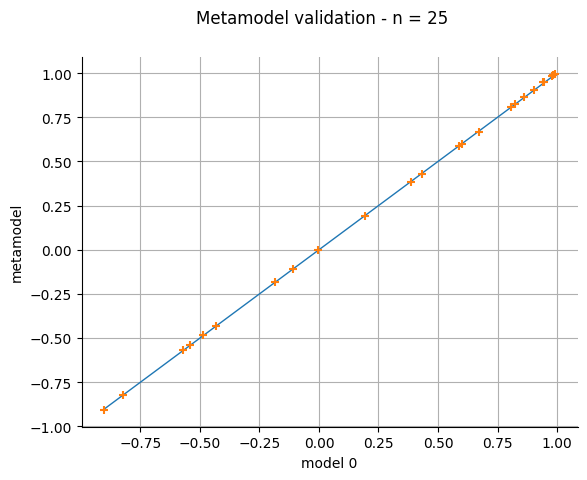

In [27]:
# Display results and OpenTURNS validation plot
print(f"R² Score: {r2Score[0]:.4f}")
from openturns.viewer import View
View(graph).show()

## Cross-Validation for Metamodel Assessment

**Why K-fold Cross-Validation?**

1. **Robust Performance Estimate**: Single train-test split can be misleading due to lucky/unlucky data splits
2. **Better Use of Limited Data**: All data points are used for both training and validation
3. **Uncertainty Quantification**: Provides mean ± std deviation of performance metrics
4. **Overfitting Detection**: Consistent performance across folds indicates good generalization

**Methodology (Kleijnen & Sargent 2000)**:
- Split fractional factorial design into k folds
- Train metamodel on k-1 folds, validate on remaining fold  
- Repeat k times, average performance metrics
- Compare with single holdout validation to assess robustness

**Expected Outcome**: CV should provide more conservative (realistic) performance estimate than single validation.

In [28]:
# K-fold Cross-Validation
import numpy as np

def k_fold_cross_validation(x_data, y_data, k=5, total_degree=3):
    """
    Perform k-fold cross-validation for metamodel validation
    
    Parameters:
    - x_data: input training data
    - y_data: output training data  
    - k: number of folds
    - total_degree: polynomial degree for metamodel
    
    Returns:
    - cv_scores: R² scores for each fold
    - mean_score: average R² score
    - std_score: standard deviation of R² scores
    """
    
    n_samples = x_data.getSize()
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    fold_size = n_samples // k
    cv_scores = []
    
    print(f"Performing {k}-fold cross-validation...")
    print(f"Total samples: {n_samples}, Fold size: ~{fold_size}")
    
    for fold in range(k):
        # Define test indices for current fold
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size if fold < k-1 else n_samples
        test_indices = indices[start_idx:end_idx]
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        
        # Split data into training and validation
        x_train_fold = ot.Sample([x_data[i] for i in train_indices])
        y_train_fold = ot.Sample([y_data[i] for i in train_indices])
        x_val_fold = ot.Sample([x_data[i] for i in test_indices])
        y_val_fold = ot.Sample([y_data[i] for i in test_indices])
        
        # Build metamodel for this fold
        polynomialCollection = [f'x^{degree + 1}' for degree in range(total_degree)]
        basis = ot.SymbolicFunction(['x'], polynomialCollection)
        designMatrix = basis(x_train_fold)
        leastSquares = ot.LinearLeastSquares(designMatrix, y_train_fold)
        leastSquares.run()
        leastSquaresModel = leastSquares.getMetaModel()
        metaModel_fold = ot.ComposedFunction(leastSquaresModel, basis)
        
        # Validate on fold test set
        y_pred_fold = metaModel_fold(x_val_fold)
        val_fold = ot.MetaModelValidation(y_val_fold, y_pred_fold)
        r2_fold = val_fold.computeR2Score()[0]
        
        cv_scores.append(r2_fold)
        print(f"Fold {fold + 1}: R² = {r2_fold:.4f} (train: {len(train_indices)}, val: {len(test_indices)})")
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    return cv_scores, mean_score, std_score

# Perform k-fold cross-validation
k = 5
cv_scores, mean_cv_score, std_cv_score = k_fold_cross_validation(x_train, y_train, k=k, total_degree=3)

print(f"\n{k}-Fold Cross-Validation Results:")
print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean R² Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"Single holdout R² Score: {r2Score[0]:.4f}")

# Compare CV performance with single validation
print(f"\nComparison:")
print(f"Cross-validation provides more robust estimate: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"Single validation might be optimistic: {r2Score[0]:.4f}")

Performing 5-fold cross-validation...
Total samples: 13, Fold size: ~2
Fold 1: R² = 0.9992 (train: 11, val: 2)
Fold 2: R² = 0.9992 (train: 11, val: 2)
Fold 3: R² = 0.9596 (train: 11, val: 2)
Fold 4: R² = 1.0000 (train: 11, val: 2)
Fold 5: R² = 0.9999 (train: 8, val: 5)

5-Fold Cross-Validation Results:
Individual fold scores: ['0.9992', '0.9992', '0.9596', '1.0000', '0.9999']
Mean R² Score: 0.9916 ± 0.0160
Single holdout R² Score: 1.0000

Comparison:
Cross-validation provides more robust estimate: 0.9916 ± 0.0160
Single validation might be optimistic: 1.0000


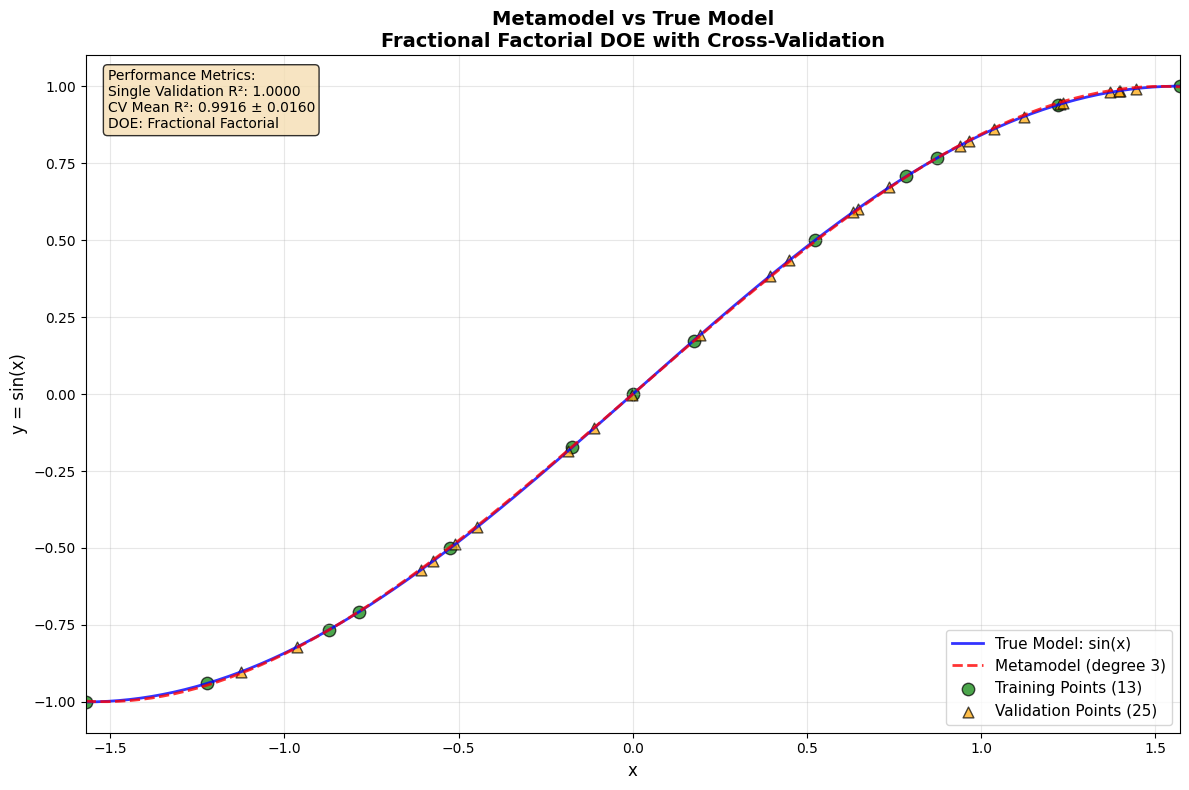

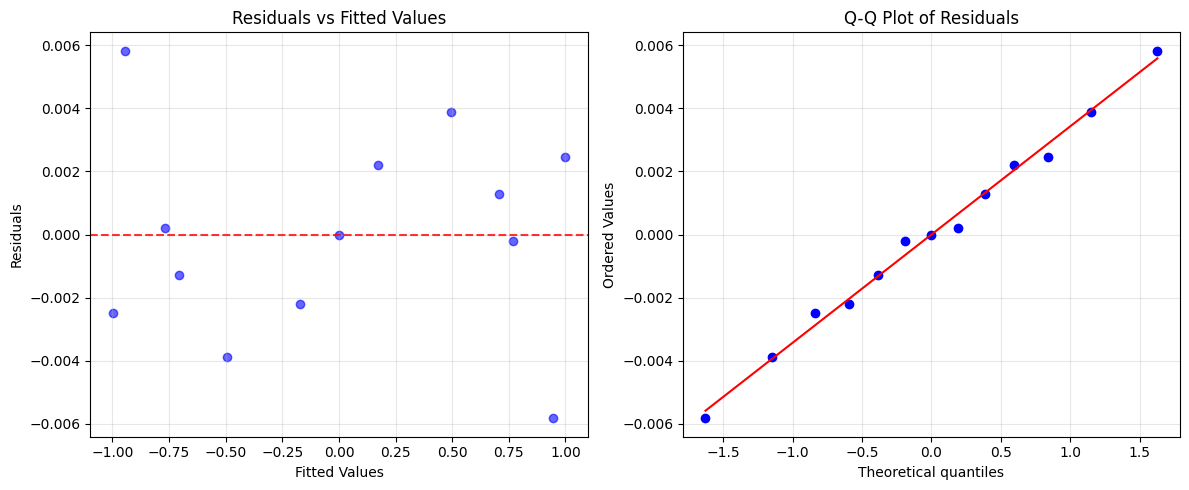

In [29]:
# Plot metamodel vs true model comparison
import matplotlib.pyplot as plt

# Generate fine grid for smooth plotting
x_plot = np.linspace(domain[0], domain[1], 200)
x_plot_ot = ot.Sample([[x] for x in x_plot])

# Evaluate true model and metamodel on fine grid
y_true_plot = model(x_plot_ot)
y_meta_plot = metaModel(x_plot_ot)

# Extract values for matplotlib
x_plot_vals = [x[0] for x in x_plot_ot]
y_true_vals = [y[0] for y in y_true_plot]
y_meta_vals = [y[0] for y in y_meta_plot]
x_train_vals = [x[0] for x in x_train]
y_train_vals = [y[0] for y in y_train]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot true model
plt.plot(x_plot_vals, y_true_vals, 'b-', linewidth=2, label='True Model: sin(x)', alpha=0.8)

# Plot metamodel
plt.plot(x_plot_vals, y_meta_vals, 'r--', linewidth=2, label=f'Metamodel (degree {total_degree})', alpha=0.8)

# Plot training points from fractional factorial design
plt.scatter(x_train_vals, y_train_vals, c='green', s=80, marker='o', 
           label=f'Training Points ({n_training})', alpha=0.7, edgecolors='black', linewidth=1)

# Plot validation points
x_test_vals = [x[0] for x in x_test]
y_test_vals = [y[0] for y in y_test]
plt.scatter(x_test_vals, y_test_vals, c='orange', s=60, marker='^', 
           label=f'Validation Points ({n_validation})', alpha=0.7, edgecolors='black', linewidth=1)

# Formatting
plt.xlabel('x', fontsize=12)
plt.ylabel('y = sin(x)', fontsize=12)
plt.title('Metamodel vs True Model\nFractional Factorial DOE with Cross-Validation', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xlim(domain[0], domain[1])

# Add performance metrics as text box
textstr = f'''Performance Metrics:
Single Validation R²: {r2Score[0]:.4f}
CV Mean R²: {mean_cv_score:.4f} ± {std_cv_score:.4f}
DOE: {design_type}'''

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Additional residual analysis plot
plt.figure(figsize=(12, 5))

# Residuals vs fitted values
plt.subplot(1, 2, 1)
y_pred_train = metaModel(x_train)
residuals_train = [y_train_vals[i] - y_pred_train[i][0] for i in range(len(y_train_vals))]
y_pred_train_vals = [y[0] for y in y_pred_train]

plt.scatter(y_pred_train_vals, residuals_train, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.grid(True, alpha=0.3)

# Q-Q plot for residual normality
from scipy import stats
plt.subplot(1, 2, 2)
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Take away

A metamodel is modified until it is valid for all experimental conditions tested:
- Explore the experimental space through DoE
- Metamodel selection
- Tune hyperparameters

Validity criterion: here R² score (see also ARE, NRMSE, etc.)
Use same criterion to compare metamodel and simulation and metamodel and problem entity.

## References

**Kleijnen**, Jack P. C., and Robert G. Sargent. ‘A Methodology for Fitting and Validating Metamodels in Simulation1’. European Journal of Operational Research 120, no. 1 (2000): 14–29. https://doi.org/10.1016/S0377-2217(98)00392-0.

**Kianifar**, Mohammed Reza, and Felician Campean. ‘Performance Evaluation of Metamodelling Methods for Engineering Problems: Towards a Practitioner Guide’. Structural and Multidisciplinary Optimization 61, no. 1 (2020): 159–86. https://doi.org/10.1007/s00158-019-02352-1.

**Kleijnen, J. P. C. (2015)**  
*Design and Analysis of Simulation Experiments*  
Springer International Publishing

**Sargent, R. G. (2013)**  
*Verification and validation of simulation models*  
Journal of Simulation, 7(1), 12-24

**Myers, R. H., Montgomery, D. C., & Anderson-Cook, C. M. (2016)**  
*Response Surface Methodology: Process and Product Optimization Using Designed Experiments*  
John Wiley & Sons

**OpenTURNS Documentation**  
*MetaModelValidation class*  
https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.MetaModelValidation.html